# The effect of synthetic data samples on timeseries classification task
 In this task we will attempt to evaluate the effect of pre-training a model on synthetic data before training it for Electrocardiogram evaluation.
  First we import needed python- libraries and read a csv file containing ECG recordings. All recordings are of V1 lead, and are a part of MIMIC-IV-ECG dataset provided by MIT. Since there is no free acess to SQL-database containing the diagnoses, the judgement call was based on amount of recordings inside one patients' folder. If the amount of recordings in a folder exceed 5, it was considered reasonable to assume that most of the recordings raised suspision with the nurse. Further evaluation following this article has confirmed noticeble difference between healthy and sick ECG-recordings.

In [1]:
!pip install kagglehub
!pip install tsgm
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import numpy as np
import tsgm
import tsgm.models.augmentations as augmentation
import tsgm.models.architectures as arch
import tsgm.models as models
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
from tensorflow import keras
import sklearn 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import pandas as pd
import math
import kagglehub

2025-06-23 15:35:31.559960: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 15:35:31.592391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
seq_length = 250
num_classes = 2
tr_stages = 2 + 1   #Amount +1, since printing start at 1
epochs = 50
batch_size = 13

In [3]:
filtered_data = {}
treatment_data = {}

path = kagglehub.dataset_download("kirilltervoridor/mimic-iv-ecg-dataset")
with open(path + "/ECG_dataset.csv", "r") as ECG_ds:
    fieldnames = ["Healthy", "Treated"]
    reader = csv.DictReader(ECG_ds,fieldnames=fieldnames)
    i = 1
    for row in reader:
        filtered = row["Healthy"].replace("[","")
        filtered = filtered.replace("]","")
        treated = row["Treated"].replace("[","")
        treated = treated.replace("]","")
        if filtered != "":
            filtered_data.setdefault(int(i),float(2))
            filtered_data[int(i)] = list(filtered.split(","))
        
        treatment_data.setdefault(int(i),float(2))
        treatment_data[int(i)] = list(treated.split(","))
        
        i += 1

## Ancillary functions
 Theese are functions, that needed definition during experementing stage and were further used to keep the code clean. Most of them are described with a name and complete certain data manipulations.

In [4]:
def get_started(aug_meth, data):
    inst = np.shape(data)[0]
    time = np.linspace(0,10,seq_length)
    x_data = np.repeat([time],inst, axis=0)
    x_data = np.expand_dims(x_data,axis=-1).astype(np.float32)
    data = data.astype(np.float32)
    if aug_meth == "WindowWraping":
        aug_model = augmentation.WindowWarping()
        aug_x = aug_model.generate(X=np.expand_dims(data,-1), n_samples=data.shape[0], scales=(0.5,1), window_ratio=0.4)
        dataset = tf.constant(aug_x,dtype=tf.float32)
    elif aug_meth == "Shuffle":
        aug_model = augmentation.Shuffle()
        aug_x = aug_model.generate(X=np.expand_dims(data,-1), n_samples=data.shape[0])
        dataset= tf.constant(aug_x,dtype=tf.float32)
    elif aug_meth == "GaussianNoise":
        aug_model = augmentation.GaussianNoise()
        aug_x = aug_model.generate(X=np.expand_dims(data,-1), n_samples=data.shape[0],mean=0.03,variance=0.008)
        dataset = tf.constant(aug_x,dtype=tf.float32)
    else:
        dataset = tf.constant(data,dtype=tf.float32)
    x_data = tf.constant(x_data,dtype=tf.float32)
    dataset = tf.squeeze(dataset)

    
    return x_data, dataset

In [5]:
def gen_vector(n,data):
    inst = np.shape(data)[0]
    tmp_latent = tf.random.normal(shape=(n, seq_length, 1))
    vector_labels = tf.concat([tmp_latent, data[:n, :, None]], axis=2)
    
    return vector_labels, data

In [6]:
def generate_labels(filtered,treated):
    X_data = np.vstack((filtered,treated))
    X_data = X_data.reshape(np.shape(X_data)[0],np.shape(X_data)[1])
    healthy = np.zeros([len(filtered),1])
    sick = np.ones([len(treated),1])
    Y_data = np.vstack((healthy,sick))
    out = []
    for i in range (len(Y_data)):
        if Y_data[i] == 1:
            out.append([0,1])
        elif Y_data[i] == 0:
            out.append([1,0])
    return tf.constant(X_data,dtype=tf.float32), tf.constant(out,dtype=tf.float32)

In [7]:
def to_single(labels):
    rep = []
    for i in range(len(labels)):
        Res = max(labels[i])
        Res_i = list(labels[i]).index(Res)
        rep.append(Res_i)
    return rep

In [8]:
def compare(Result, true_labels):
    if len(Result) != len(true_labels):
        print("Sequence lengths did not match.")
        return None
    w = 0
    for i in range(len(Result)):
        Res = max(Result[i])
        Res_i = list(Result[i]).index(Res)
        if Res_i == list(true_labels[i]).index(1):
            w+=1
    return w/len(Result)

In [9]:
def distances(data):
    count=1
    ou = []
    out = []
    for item in data:
        for k in range(len(item)):
            if item[k] == 0:
                count += 1
            elif item[k] != 0:
                ou.append(count)
                count = 1
        if len(ou) > 3:
            while len(ou) < 30:
                ou.append(0)
            out.append(list(ou)[:30])
            ou.clear()
        else:
            ou.clear()
    return out

In [10]:
def modify_and_label(filtered,treated, cut=0.2):
    for item in filtered:
        for g in range(len(item)):
            if item[g] < cut:
                item[g] = 0
    for item in treated:
        for k in range(len(item)):
            if item[k] < cut:
                item[k] = 0
    filtered = distances(filtered)
    treated = distances(treated)
    X_data = []
    for item in filtered:
        X_data.append(item)
    for item in treated:
        X_data.append(item)
    healthy = np.zeros([len(filtered),1])
    sick = np.ones([len(treated),1])
    Y_data = np.vstack((healthy,sick))
    out = []
    for i in range (len(Y_data)):
        if Y_data[i] == 1:
            out.append([0,1])
        elif Y_data[i] == 0:
            out.append([1,0])
    return tf.constant(X_data,dtype=tf.float32), tf.constant(out,dtype=tf.float32)

In [11]:
def halve_data(data):
    dat_dic = {}
    out_dic = {}
    for key, value in data.items():
        dat, out = np.split(np.array(value,dtype=np.float32),2)
        dat_dic[key] = dat
        out_dic[key] = out
    return dat_dic, out_dic

In [12]:
def train_test_split(data, seq_length, current_length):
    prc = len(data) / 4
    tr = int(prc*2)
    tes = int(prc*3)
    splitter = current_length/seq_length
    train = np.zeros([tr-2,current_length])
    test = np.zeros([tes,current_length])


    for key, value in data.items():
        if key < tr-2:
            train[key-1] = np.array(data[key],dtype=np.float32)
        elif key >= tes:
            test[key-tes-1] = np.array(data[key],dtype=np.float32)
    
    train_s = np.zeros([tr-2,seq_length])
    test_s = np.zeros([tes,seq_length])
    tr_li = []
    tes_li = []
    for i in range(0,train.shape[0]):
        for j in range(0,train.shape[1]):
            if j % int(splitter) == 0:
                tr_li.append(train[i][j])
                tes_li.append(test[i][j])
        train_s[i] = np.array(tr_li, dtype=np.float32)
        test_s[i] = np.array(tes_li, dtype=np.float32)
        tr_li.clear()
        tes_li.clear()

    

    return(train_s,test_s)

filtered1, filtered0 = halve_data(filtered_data)
train_f1, test_f1  = train_test_split(data=filtered0, seq_length=seq_length, current_length=5000)
train_f2, test_f2 = train_test_split(data=filtered1, seq_length=seq_length, current_length=5000)
train_t,test_t = train_test_split(data=treatment_data, seq_length=seq_length, current_length=5000)
print(train_f1.shape)
print(train_f2.shape)
print(test_t.shape)

(135, 250)
(135, 250)
(288, 250)


# Synthetic data generation
 To generate the data samples we will use TSGM-library and temporal version of Generative Aversarial model provided with it.

In [13]:
architecture = arch.zoo["t-cgan_c4"](seq_len=seq_length,feat_dim=1,latent_dim=1,output_dim=1)

In [14]:

GAN_Control = models.cgan.ConditionalGAN(discriminator=architecture.discriminator,generator=architecture.generator, latent_dim=1, temporal=True) 
GAN_Control.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.000017,epsilon=1e-9),g_optimizer=keras.optimizers.Adam(learning_rate=0.000113,epsilon=1e-8),loss_fn=keras.losses.BinaryCrossentropy()) 

In [15]:
x_data, dataset = get_started(aug_meth="",data=train_t)

datum = tf.data.Dataset.from_tensor_slices((x_data,dataset))
datum = datum.batch(5)

GAN_Control.fit(datum,epochs=3)

Epoch 1/3
38/38 [==============================] - 94s 2s/step - g_loss: 0.6929 - d_loss: 0.6351
Epoch 2/3
38/38 [==============================] - 89s 2s/step - g_loss: 0.6932 - d_loss: 0.4732
Epoch 3/3
38/38 [==============================] - 88s 2s/step - g_loss: 0.6945 - d_loss: 0.4029


In [16]:
generator_labels = tf.constant(np.ones([99,1]),dtype=tf.float32)

vector_labels, test_set = gen_vector(n=99,data=dataset)

Synthetic_data = GAN_Control.generate(vector_labels[:99,:,1])

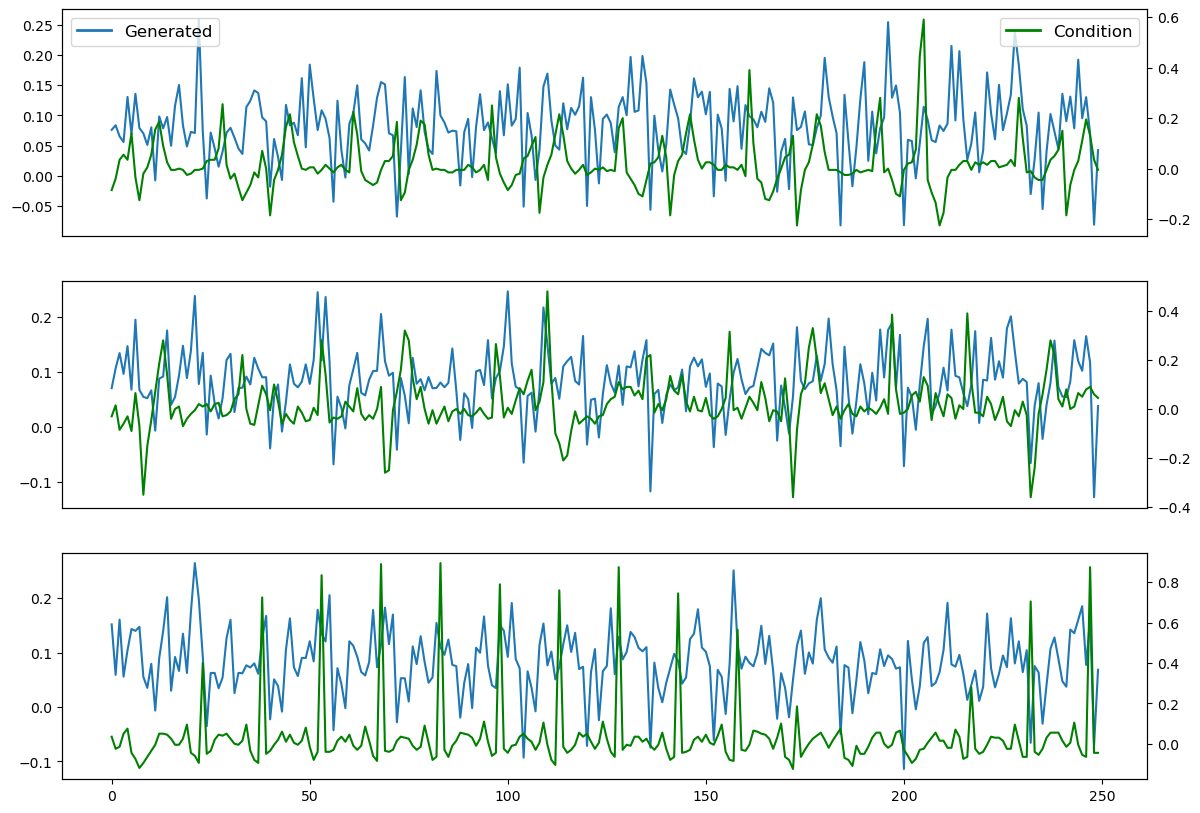

In [17]:
tsgm.utils.visualize_ts_lineplot(Synthetic_data,test_set,3)

plt.show()

# Classification model definition
For classification task we will define a LSTM-based Recurrent Neural Network. We will be training two models, first with synthetic data and other without. Both models will train for epochs x 1.5, where first one will start with epochs x 0.5 long synthetic training block and finish with epoch x 1 long ECG data training block. Model number two will have one epoch x 1.5 long training block on ECG data. 

In [18]:
class Block(keras.layers.Layer):
    def __init__(self, input_dim, output_dim, **kwargs):
        super(Block, self).__init__(**kwargs)

        self.layer1 = keras.layers.Dense(units = input_dim*5)
        self.lstm = keras.layers.LSTM(units = output_dim,activation="sigmoid",recurrent_activation="sigmoid",unit_forget_bias=False,dropout=0.30)
        self.layer2 = keras.layers.Dense(units = input_dim*15)
        self.layer3 = keras.layers.Dense(units = input_dim*5)
        self.outlayer = keras.layers.Dense(units = output_dim)
        self.activ = keras.layers.ReLU()
        self.norm = keras.layers.BatchNormalization()
      
    def get_config(self):
        config = super.get_config()
        config.update(
            {
            "layer1": self.layer1,
            "lstm": self.lstm,
            "layer2": self.layer2,
            "layer3": self.layer3,
            "outlayer": self.outlayer,
            "activation": self.activ,
            "normalization": self.norm
            }
        )
        return config
    
    
    def call(self, x):
        y = self.layer1(x)
        y = self.activ(y)
        y = tf.expand_dims(y,axis=-1)
        y = self.lstm(y,training=True)
        #y = tf.squeeze(y)
        y = self.layer2(y)
        y = self.activ(y)
        y = self.layer3(y)
        y = self.activ(y)
        y = self.norm(y)
        out = self.outlayer(y)

        
        return out


class RNN(keras.Model):
    def __init__(self, input_dim, output_dim):
        super(RNN, self).__init__()
        
        self.layer1 = Block(input_dim, output_dim)
        self.layer2 = Block(input_dim, output_dim)
        self.layer3 = Block(input_dim, output_dim)

    def call(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        out = self.layer3(y)

        return out

In [19]:
Synthetic_data = tf.squeeze(Synthetic_data)

ind = np.arange(13,seq_length,13)
x_ex = np.zeros([99,seq_length])
for item in ind:
    for i in range(0,99):
        x_ex[i,item] = 0.27

In [20]:
Classif_model = RNN(seq_length, num_classes)
loss_Fn = keras.losses.CategoricalCrossentropy()

optimizer = keras.optimizers.Adam(learning_rate=0.05,
                                  beta_1=0.8,
                                  beta_2=0.999,
                                  epsilon=1e-7)

Classif_model.compile(optimizer=optimizer,
                      loss=loss_Fn,
                      metrics=["categorical_accuracy","F1Score"])

In [21]:
for stage in range(1,tr_stages):
    if stage == 1:
        x_train, y_train = modify_and_label(x_ex, 
                                            Synthetic_data.numpy(), 
                                            cut = 0.2
                                            )
        Classif_model.fit(x= x_train,
                         y= y_train,
                         batch_size= batch_size,
                         epochs=math.ceil(epochs/2),
                         shuffle=True
                         )
    else:
        x_train, y_train = modify_and_label(train_f1,
                                            train_t,
                                            cut = 0.2
                                           )
        Classif_model.fit(x= x_train,
                         y= y_train,
                         batch_size= batch_size,
                         epochs=epochs,
                         shuffle=True
                         )

Epoch 1/25
15/15 [==============================] - 46s 3s/step - loss: 8.9987 - categorical_accuracy: 0.5568 - f1_score: 0.5557
Epoch 2/25
15/15 [==============================] - 41s 3s/step - loss: 8.7125 - categorical_accuracy: 0.5946 - f1_score: 0.5786
Epoch 3/25
15/15 [==============================] - 41s 3s/step - loss: 8.6254 - categorical_accuracy: 0.5405 - f1_score: 0.5264
Epoch 4/25
15/15 [==============================] - 41s 3s/step - loss: 8.7125 - categorical_accuracy: 0.5135 - f1_score: 0.4932
Epoch 5/25
15/15 [==============================] - 42s 3s/step - loss: 8.6254 - categorical_accuracy: 0.5189 - f1_score: 0.5120
Epoch 6/25
15/15 [==============================] - 42s 3s/step - loss: 8.6254 - categorical_accuracy: 0.4757 - f1_score: 0.4550
Epoch 7/25
15/15 [==============================] - 42s 3s/step - loss: 8.6254 - categorical_accuracy: 0.4216 - f1_score: 0.4100
Epoch 8/25
15/15 [==============================] - 43s 3s/step - loss: 8.6254 - categorical_accu

In [22]:
x_test, y_test =  modify_and_label(test_f1,
                                   test_t,
                                   cut = 0.2)

model_labels = Classif_model.predict(x_test)

5/5 [==============================] - 3s 432ms/step


In [23]:
Classif_model2 = RNN(seq_length, num_classes)
loss_Fn = keras.losses.CategoricalCrossentropy()

optimizer = keras.optimizers.Adam(learning_rate=0.05,
                                  beta_1=0.8,
                                  beta_2=0.999,
                                  epsilon=1e-7)

Classif_model2.compile(optimizer=optimizer,
                      loss=loss_Fn,
                      metrics=["categorical_accuracy","F1Score"])

In [24]:
x_train, y_train = modify_and_label(train_f1,
                                    train_t,
                                    cut = 0.2
                                    )
Classif_model2.fit(x= x_train,
                  y= y_train,
                  batch_size= batch_size,
                  epochs=math.ceil(epochs*1.5),
                  shuffle=True
                 )

Epoch 1/75
24/24 [==============================] - 74s 3s/step - loss: 1.3237 - categorical_accuracy: 0.5402 - f1_score: 0.5323
Epoch 2/75
24/24 [==============================] - 68s 3s/step - loss: 0.6920 - categorical_accuracy: 0.4920 - f1_score: 0.4908
Epoch 3/75
24/24 [==============================] - 66s 3s/step - loss: 0.6841 - categorical_accuracy: 0.4630 - f1_score: 0.4510
Epoch 4/75
24/24 [==============================] - 64s 3s/step - loss: 0.6914 - categorical_accuracy: 0.4341 - f1_score: 0.4260
Epoch 5/75
24/24 [==============================] - 64s 3s/step - loss: 0.6824 - categorical_accuracy: 0.4566 - f1_score: 0.4384
Epoch 6/75
24/24 [==============================] - 63s 3s/step - loss: 0.8410 - categorical_accuracy: 0.4502 - f1_score: 0.4258
Epoch 7/75
24/24 [==============================] - 64s 3s/step - loss: 0.9144 - categorical_accuracy: 0.5756 - f1_score: 0.4938
Epoch 8/75
24/24 [==============================] - 70s 3s/step - loss: 0.7002 - categorical_accu

In [25]:
x_test, y_test =  modify_and_label(test_f1,
                                   test_t,
                                   cut = 0.2)

model_labels2 = Classif_model2.predict(x_test)

5/5 [==============================] - 2s 393ms/step


# Model comparison
For comparison we will use accuracy score and F1-score.

In [26]:
y_examp = to_single(y_test)
model_y = to_single(model_labels)
Acc = accuracy_score(model_y,y_examp)
Con_MA = confusion_matrix(model_y,y_examp)
F1 = f1_score(model_y,y_examp)

In [34]:
y_examp2 = to_single(y_test)
model_y2 = to_single(model_labels2)
Acc2 = accuracy_score(model_y2,y_examp2)
Con_MA2 = confusion_matrix(model_y2,y_examp2)
F1_2 = f1_score(model_y2,y_examp2) 

print(f"Mixed model accuracy: {Acc:.2f} vs Regular model accuracy: {Acc2:.2f} \n")
print(f" Mixed model confusion matrix: \n{Con_MA} \nvs")
print(f" Regular model confusion matrix: \n{Con_MA2}")
print(f"\n Mixed model F1-score: {F1:.2f} vs Regular model F1-score: {F1_2:.2f}")

Mixed model accuracy: 0.54 vs Regular model accuracy: 0.50 

 Mixed model confusion matrix: 
[[24 29]
 [43 61]] 
vs
 Regular model confusion matrix: 
[[19 31]
 [48 59]]

 Mixed model F1-score: 0.63 vs Regular model F1-score: 0.60
